Finding the centroid of segmented nuclei and cropping image
1. Load the zarr file containing the masks and determine the number of treatments and masks
2. Iterate through the masks to: remove boundary objects and determine the centroid for each instance segmentation


In [5]:
import zarr
import numpy as np

# Load zarr file
z= zarr.open("/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr", mode="r")

# Explore zarr to find treatments and masks

treatments = list(z.keys())
for treatment in treatments:
    print(f"Treatment: {treatment} has {z[treatment]['masks'].shape[0]} masks")
    print(f"Mask shape: {z[treatment]['masks'].shape}")


Treatment: 1uMdoxo has 115 masks
Mask shape: (115, 512, 512)
Treatment: DMSO has 115 masks
Mask shape: (115, 512, 512)
Treatment: 10uMmg132 has 115 masks
Mask shape: (115, 512, 512)
Treatment: 5uMflavo has 115 masks
Mask shape: (115, 512, 512)
Treatment: 800nMActD has 145 masks
Mask shape: (145, 512, 512)
Treatment: 10uMwort has 115 masks
Mask shape: (115, 512, 512)
Treatment: CX5461 has 115 masks
Mask shape: (115, 512, 512)
Treatment: 8nMActD has 115 masks
Mask shape: (115, 512, 512)


2. Iterate through the masks to: remove boundary objects and determine the centroid for each instance segmentation

In [4]:
from skimage.segmentation import clear_border
from skimage.measure import regionprops

sample_mask=z["DMSO"]["masks"][0]  # Example mask for DMSO treatment
raw_image=z["DMSO"]["raw"][0]  # Corresponding raw image
print(sample_mask.shape, sample_mask.dtype)
print(raw_image.shape, raw_image.dtype)
cleared_border = clear_border(sample_mask)
padded_mask = np.pad(cleared_border, pad_width=64, mode='constant', constant_values=0)
padded_raw = np.pad(raw_image, pad_width=((0, 0),(0, 0),(64, 64), (64, 64)), mode='symmetric')
props_num = len(regionprops(padded_mask))
print(f"Number of nuclei in mask: {props_num}")
cropped_raw_np = np.zeros((props_num, 15, 3, 128, 128), dtype=np.uint8)
cropped_mask_np = np.zeros((props_num, 1, 128, 128), dtype=np.int32)
print(f"cropped masks array shape: {cropped_mask_np.shape}")
print(f"cropped raw array shape: {cropped_raw_np.shape}")
for i, props in enumerate(regionprops(padded_mask)):
    centroid = props.centroid
    print(centroid)
    crop_box = [int(centroid[0])-64, int(centroid[0])+64, int(centroid[1])-64, int(centroid[1])+64]
    raw_crop = padded_raw[:,:,crop_box[0]:crop_box[1], crop_box[2]:crop_box[3]]
    mask_crop = padded_mask[crop_box[0]:crop_box[1], crop_box[2]:crop_box[3]]
    mask_bool = mask_crop == props.label
    raw_crop[:, :, ~mask_bool] = 0
    cropped_raw_np[i] = raw_crop
    cropped_mask_np[i] = mask_bool
print(f"cropped masks array shape: {cropped_mask_np.shape}")
print(f"cropped raw array shape: {cropped_raw_np.shape}")


(512, 512) int32
(15, 3, 512, 512) uint8
Number of nuclei in mask: 22
[<skimage.measure._regionprops.RegionProperties object at 0x7f808cacbe10>, <skimage.measure._regionprops.RegionProperties object at 0x7f808cacaa50>, <skimage.measure._regionprops.RegionProperties object at 0x7f808caa3c90>, <skimage.measure._regionprops.RegionProperties object at 0x7f808caa0c90>, <skimage.measure._regionprops.RegionProperties object at 0x7f808caa0e10>, <skimage.measure._regionprops.RegionProperties object at 0x7f808caa3d90>, <skimage.measure._regionprops.RegionProperties object at 0x7f808caa31d0>, <skimage.measure._regionprops.RegionProperties object at 0x7f808caa1210>, <skimage.measure._regionprops.RegionProperties object at 0x7f808caa1350>, <skimage.measure._regionprops.RegionProperties object at 0x7f808caa3b90>, <skimage.measure._regionprops.RegionProperties object at 0x7f808caa3e50>, <skimage.measure._regionprops.RegionProperties object at 0x7f808caa1410>, <skimage.measure._regionprops.RegionPrope

View images

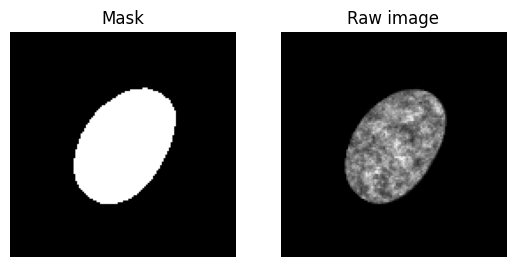

In [37]:
import matplotlib.pyplot as plt

#load examples
sample_mask = cropped_mask_np[0, 0]
sample_raw = cropped_raw_np[0, 7, 0]
#visualize cleared mask
fig, axes = plt.subplots(1, 2)
axes[0].imshow(sample_mask, cmap="gray")
axes[0].set_title(f"Mask")
axes[0].axis("off")
axes[1].imshow(sample_raw, cmap="gray")
axes[1].set_title(f"Raw image")
axes[1].axis("off")
plt.show()